# Modelo Preditivo - Business Case

## Importações

In [29]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso


In [5]:
# Importando dataset
df_energy = pd.read_csv('..\Data\dataset_eda.csv', index_col=0)
df_energy.head()

,horario,dia,mes,energia,cor_atrasada,cor_principal,med_CO2,fat_pot_atrasado,fat_pot_principal,seg_no_dia,est_semanal,dia_semana,carga
0,00:15:00,1,1,3.17,2.95,0.0,0.0,73.21,100.0,900,Dia da Semana,Segunda-feira,Carga leve
1,00:30:00,1,1,4.00,4.46,0.0,0.0,66.77,100.0,1800,Dia da Semana,Segunda-feira,Carga leve
2,00:45:00,1,1,3.24,3.28,0.0,0.0,70.28,100.0,2700,Dia da Semana,Segunda-feira,Carga leve
3,01:00:00,1,1,3.31,3.56,0.0,0.0,68.09,100.0,3600,Dia da Semana,Segunda-feira,Carga leve
4,01:15:00,1,1,3.82,4.50,0.0,0.0,64.72,100.0,4500,Dia da Semana,Segunda-feira,Carga leve


## Tratando outliers

As outliers que são mais preocupantes são as de carga baixa, vistas na análise exploratória de dados. De acordo com estudo a respeito da relação entre a carga e as correntes, entende-se que quando há muita demanda da corrente a carga tende a ser alta. Entretanto, como visto nos dados há situações onde a corrente atrasada tem um valor muito alto, mas a carga está como baixa. Acredita-se que estes dados da carga são erros de entrada de informação. 

Nesse modelo, a informação da carga não será utilizada, mas da mesma forma, na busca de não prejudicar o modelo, os dados outliers do consumo de energia serão removidos da base de dados exceto os do mês preditivo (mês de dezembro). 

In [6]:
# Filtrar os dados para a carga "Carga Leve"
df_carga_leve = df_energy[df_energy['carga'] == 'Carga leve']
df_carga_leve.describe()

,dia,mes,energia,cor_atrasada,cor_principal,med_CO2,fat_pot_atrasado,fat_pot_principal,seg_no_dia
count,18072.000000,18072.000000,18072.000000,18072.000000,18072.000000,18072.000000,18072.000000,18072.000000,18072.000000
mean,15.644090,6.517928,8.626207,7.004266,2.944328,0.002554,69.679545,85.409154,28384.661355
std,8.875802,3.520230,17.906245,11.683405,6.402794,0.008726,18.951731,30.070037,24108.527732
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,3.000000,2.950000,3.020000,0.000000,0.000000,52.700000,100.000000,10800.000000
50%,16.000000,7.000000,3.310000,4.460000,0.000000,0.000000,66.270000,100.000000,21600.000000
75%,23.000000,10.000000,4.030000,5.440000,0.000000,0.000000,82.922500,100.000000,33300.000000
max,31.000000,12.000000,140.290000,96.910000,27.760000,0.060000,100.000000,100.000000,85500.000000


In [7]:
# Criando váriavel outlier - energia
outlier = (4.03) + (1.5 * (4.03 - 2.95))

# Contar a quantidade de outliers
out_count = np.sum(df_carga_leve['energia'] > outlier)

# Exibir a quantidade de outliers
print("Quantidade de outliers:", out_count)

Quantidade de outliers: 2269


In [8]:
# Removendo as linhas de carga leve que são outliers com excessão do mês de dezembro
df = df_energy.loc[(df_energy.energia < outlier)| (df_energy.mes == 12)| (df_energy.carga != 'Carga leve')]
df = df[['dia',	'mes', 'energia', 'cor_atrasada', 'cor_principal', 'med_CO2', 'fat_pot_atrasado', 'fat_pot_principal']]
df.head()


,dia,mes,energia,cor_atrasada,cor_principal,med_CO2,fat_pot_atrasado,fat_pot_principal
0,1,1,3.17,2.95,0.0,0.0,73.21,100.0
1,1,1,4.00,4.46,0.0,0.0,66.77,100.0
2,1,1,3.24,3.28,0.0,0.0,70.28,100.0
3,1,1,3.31,3.56,0.0,0.0,68.09,100.0
4,1,1,3.82,4.50,0.0,0.0,64.72,100.0


## Modelo

Sobre o modelo

- Agrupamento dos dados: Para este modelo os dados não foram agrupados por hora ou por dia em virtude de algumas features que poderiam ser prejudicadas no decorrer deste. Os fatores de potencia são dados percentuais e realizando este agrupamento poderia prejudicar o valor real deste que em algum momento poderia estar em cem porcento e em outro momento em 50, mas ao soma-los, a relação deste componete com o valor da corrente seria perdida. Outra informação comprometida seria a carga da energia, porem esta informação não prejudicaria tanto pois não é usada na construção do modelo.
- Separação das features: para não inviesar o modelo as features como dia da semana, estado semanal, segundos do dia, data e horario e carga foram removidas. Estas não contribui no aprendizado quanto a quantidade de energia usada. As informações que tem causalidade na quantidade de energia usada são as correntes, fator de potência e quantidade de CO2, com isso, essas foram as features escolhidas para o modelo. A principio, iria utilizar a carga também, mas apenas com as 5 features apresentadas já informa o nível da carga utlizada.
- Serão usados dois modelos preditivos, knn regression, regressão linear e random forest regression. Esses modelos foram escolhidos pois tratando de predição de valor contínuo, são os modelos que mais se enquadram com o projeto. 


### Separação dos dados de treino e teste

A separação dos dados de treino e teste serão realizadas manualmente, pois como os dados são divididos em resgitros a cada 15 minutos, o modelo realizará a predição de todos os registros agrupando os valores da energia consumida, assim realizando a predição mensal. E para obter a predição do mês de dezembro como um todo, utilizando o train_test_split() a divisão dos dados de treino e de teste seria feita de forma aleatória e não é esse o intuito do projeto. Com isso foram selecionados os dados de janeiro até novembro para realizar o treino do modelo e os do mês de dezembro para o teste.

In [9]:
# Separando os dados de treino e de teste de acordo com o mês
train = df.loc[df.mes != 12]
test = df.loc[df.mes == 12] # o mês de dezembro será o mês preditivo, por isso está sendo separado para teste

In [10]:
# Separando as features e target de treino e teste
X_train = train[['cor_atrasada','cor_principal', 'med_CO2',	'fat_pot_atrasado',	'fat_pot_principal']]
y_train = train['energia']
X_test = test[['cor_atrasada','cor_principal', 'med_CO2',	'fat_pot_atrasado',	'fat_pot_principal']]
y_test = test['energia']

### KNN Regression

#### Treinando o modelo

Será utilizado o Standard Scaler, no qual os dados serão padronizados com média zero e desvio padrão igual a 1. Essa padronização garante que todas as variáveis tenham a mesma escala, o que evita que algumas variáveis dominem outras por simplesmente terem valores maiores. Para o modelo de KNN é importante realizar essa padronização pois é um algoritmo que usa medida de distancia e as diferenças de escala podem afetar negativamente o desempenho do algoritmo.

In [11]:
# Padronizando os dados das features e transformação dos dados
SDS = StandardScaler()
X_train_std = SDS.fit_transform(X_train)
X_test_std = SDS.transform(X_test)


Plotando a curva de aprendizado em relação ao Erro médio quadratico e o valor de k vizinhos, para definir o valor de k vizinhos do modelo

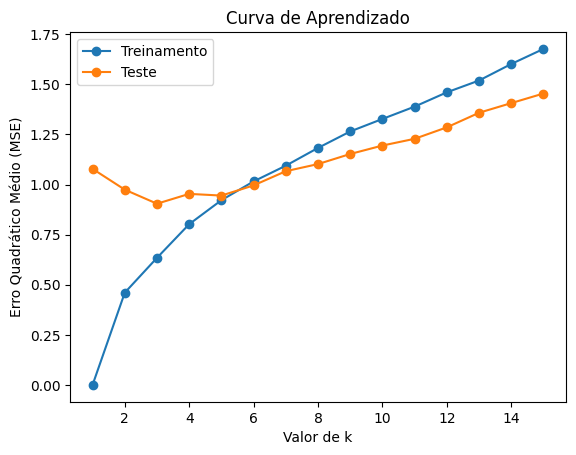

In [122]:
# Lista de valores de k a serem testados
k_values = range(1, 16)

# Listas para armazenar os resultados
mse_sc_train = []
mse_sc_test = []

# Loop para testar diferentes valores de k
for k in k_values:
    # Modelo KNN Regression
    KNN = KNeighborsRegressor(n_neighbors=k)
    
    # Treinando o modelo
    KNN.fit(X_train_std, y_train)
    
    # Fazendo previsões no conjunto de treinamento e calculando o MSE
    y_pred_train = KNN.predict(X_train_std)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_sc_train.append(mse_train)
    
    # Fazendo previsões no conjunto de teste e calculando o MSE
    y_pred_test = KNN.predict(X_test_std)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_sc_test.append(mse_test)

# Plotando a curva de aprendizado
plt.plot(k_values, mse_sc_train,'o-', label='Treinamento')
plt.plot(k_values, mse_sc_test,'o-', label='Teste')
plt.title('Curva de Aprendizado')
plt.xlabel('Valor de k')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.legend()
plt.show()

In [13]:
# Gerando o primeiro modelo
KNN = KNeighborsRegressor(n_neighbors= 8)

In [14]:
# Treinando o modelo com os dados de treino
KNN.fit(X_train_std, y_train)

KNeighborsRegressor(n_neighbors=8)

In [15]:
# Realizando a predição do modelo com os dados de teste
KNNy_pred_train = KNN.predict(X_train_std)
KNNy_pred_test = KNN.predict(X_test_std)

#### Avaliação do modelo

Para avaliar o modelo serão utilizadas as métricas de avaliação: MSE - Mean Squared Errror, R2 - R-Squared e R2 Ajustado - R-Squared Ajustado. As três métricas irão auxiliar na verificação do modelo, se está com indícios de overfitting, desempenhando mal ou se as features utilizadas atuam bem na construção do modelo.

In [16]:
df.describe()

,dia,mes,energia,cor_atrasada,cor_principal,med_CO2,fat_pot_atrasado,fat_pot_principal
count,32881.000000,32881.000000,32881.000000,32881.000000,32881.000000,32881.000000,32881.000000,32881.000000
mean,15.691311,6.630942,26.245774,11.884489,4.107325,0.010964,80.603651,83.394015
std,8.751626,3.419568,33.244568,15.340524,7.583959,0.016030,19.433165,31.139089
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,4.000000,3.170000,1.580000,0.000000,0.000000,61.850000,99.100000
50%,16.000000,7.000000,4.180000,4.820000,0.000000,0.000000,88.990000,100.000000
75%,23.000000,10.000000,50.080000,19.220000,4.030000,0.020000,99.750000,100.000000
max,31.000000,12.000000,157.180000,87.590000,27.760000,0.070000,100.000000,100.000000


In [17]:
# Calculando o Mean Squared Error
mse_train = mean_squared_error(y_train, KNNy_pred_train)
mse_test = mean_squared_error(y_test, KNNy_pred_test)

# Calculando o R-Squared
r2_train = r2_score(y_train, KNNy_pred_train)
r2_test = r2_score(y_test, KNNy_pred_test)

# Número de observações e número de variáveis preditoras de treino
n_train = len(X_train_std)
p_train = X_train_std.shape[1]

# Número de observações e número de variáveis preditoras de teste
n_test = len(X_test_std)
p_test = X_test_std.shape[1]

# Calculando o R-Squared Ajustado
r2_ajustado_train = 1 - (1 - r2_train) * ((n_train - 1) / (n_train - p_train - 1))
r2_ajustado_test = 1 - (1 - r2_test) * ((n_test - 1) / (n_test - p_test - 1))

Mean Squared Error (MSE) - Treinamento: 1.1828699103410798
Mean Squared Error (MSE) - Teste: 1.1022945926789318
R² - Treinamento: 0.9989408149679188
R² - Teste: 0.998874158723009
R² ajustado - Treinamento: 0.9989406378407519
R² ajustado - Teste: 0.9988722633673238


In [ ]:
# Imprimindo as métricas de avaliação
print("Mean Squared Error (MSE) - Treinamento:", mse_train)
print("Mean Squared Error (MSE) - Teste:", mse_test)

print("R² - Treinamento:", r2_train)
print("R² - Teste:", r2_test)

print("R² ajustado - Treinamento:", r2_ajustado_train)
print("R² ajustado - Teste:", r2_ajustado_test)


Mean Squared Error (MSE): Tanto o MSE de treinamento quanto o de teste são relativamente baixos, o que indica um bom desempenho do modelo em relação ao ajuste dos dados.

R² (R-squared): Tanto o R² de treinamento quanto o de teste são próximos de 1, o que indica que uma grande proporção da variabilidade dos dados está sendo explicada pelo modelo. Isso sugere um bom ajuste do modelo aos dados.

R² ajustado: O R² ajustado considera o número de variáveis preditoras no modelo, penalizando o uso excessivo de variáveis. Os valores de R² ajustado para treinamento e teste são próximos do R², o que indica que o modelo provavelmente está utilizando um número adequado de variáveis para explicar a variabilidade dos dados.

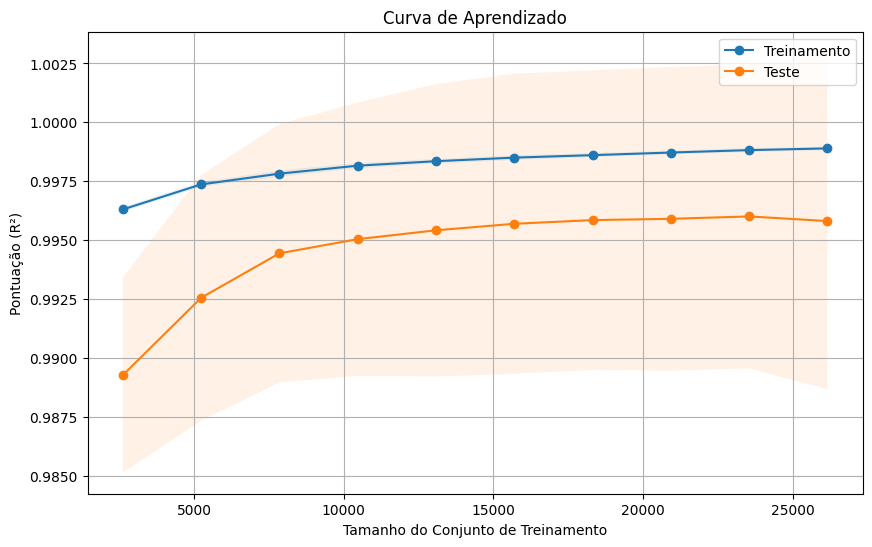

In [121]:
# Calcular a curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(KNN, X_train_std, y_train, cv=8, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

# Calcular as médias e desvios-padrão das pontuações de treinamento e teste
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)



# Plotar a curva de aprendizado
plt.figure(figsize=(10, 6))
plt.title('Curva de Aprendizado')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Pontuação (R²)')
plt.grid(True)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
plt.plot(train_sizes, train_scores_mean,'o-', label='Treinamento')
plt.plot(train_sizes, test_scores_mean,'o-', label='Teste')
plt.legend(loc='best')
plt.show()

### Linear Regression

Como a regressão linear é sensível à escala das variáveis, pois atribui pesos aos coeficientes das variáveis preditoras, o modelo também utilizará das variáveis padronizadas com Standard Scaler, para que as variáveis com valores maiores não dominem a contribuição para o modelo.

#### Treinamento do modelo

In [19]:
# Gerando o segundo modelo
LR = LinearRegression()

In [20]:
# Treinando o modelo com os dados de treino
LR.fit(X_train_std, y_train)

LinearRegression()

In [37]:
# Realizando a predição do modelo com os dados de teste
LRy_pred_train = LR.predict(X_train_std)
LRy_pred_test = LR.predict(X_test_std)
LR.score(X_test_std, y_test)

0.9869778141649932

#### Avaliação do modelo

In [23]:
# Calculando o Mean Squared Error
mse_train = mean_squared_error(y_train, LRy_pred_train)
mse_test = mean_squared_error(y_test, LRy_pred_test)

# Calculando o R-Squared
r2_train = r2_score(y_train, LRy_pred_train)
r2_test = r2_score(y_test, LRy_pred_test)

# Número de observações e número de variáveis preditoras de treino
n_train = len(X_train_std)
p_train = X_train_std.shape[1]

# Número de observações e número de variáveis preditoras de teste
n_test = len(X_test_std)
p_test = X_test_std.shape[1]

# Calculando o R-Squared Ajustado
r2_ajustado_train = 1 - (1 - r2_train) * ((n_train - 1) / (n_train - p_train - 1))
r2_ajustado_test = 1 - (1 - r2_test) * ((n_test - 1) / (n_test - p_test - 1))

# Imprimindo as métricas de avaliação
print("Mean Squared Error (MSE) - Treinamento:", mse_train)
print("Mean Squared Error (MSE) - Teste:", mse_test)

print("R² - Treinamento:", r2_train)
print("R² - Teste:", r2_test)

print("R² ajustado - Treinamento:", r2_ajustado_train)
print("R² ajustado - Teste:", r2_ajustado_test)

Mean Squared Error (MSE) - Treinamento: 21.635383725067417
Mean Squared Error (MSE) - Teste: 12.749830126279267
R² - Treinamento: 0.980626885167517
R² - Teste: 0.9869778141649932
R² ajustado - Treinamento: 0.980623645407854
R² ajustado - Teste: 0.986955891293217


Mean Squared Error (MSE): O MSE de teste foi menor que o de treino, o que significa que o erro médio ao quadrado está sendo menor nos dados de teste.
Agora, quanto ao R² e o R² ajustado estão com boas métricas, o modelo está explicando uma grande proporção da variabilidade dos dados e a quantidade de features está adequada para isto.

#### Regularização do modelo

Regularização Ridge - Será usada para evitar overfitting devido a multicolinearidade dos dados.

In [38]:
# Verificando regularização rigde
ridge = Ridge(alpha = 0.5)
ridge.fit(X_train_std, y_train)
ridge.score(X_test_std, y_test)

0.9869759173827237

Como não alterou muito o R², será mantido o modelo sem regularização.

### Random Forest Regression

Este modelo, por mais de ser custoso de acordo com a quantidade de florestas aleatórias a serem utilizadas, ele é um modelo que ajuda a mitigar o overfitting. Cada árvore é treinada em uma amostra aleatória do conjunto de dados e realiza previsões independentes. Após isso, as previsões são combinadas por meio de média para fornecer uma estimativa mais precisa.

#### Treinamento do modelo

Primeiramente, foi criado um código para verificar o valor do R² de acordo com a quantidade de estimadores, para ajustar a quantidade necessária no modelo.

In [51]:
# Lista de valores de k a serem testados
n_estimators = [x for x in range(50, 250, 50)]

In [ ]:
# Lista para armazenar os scores médios de validação cruzada
scores = []

In [67]:
for n_estimators in n_estimators:
    # Criando o modelo de Random Forest Regression com o número de estimadores atual
    RFR = RandomForestRegressor(n_estimators=n_estimators)
    
    # Realizando a validação cruzada com 5 folds
    cv_scores = cross_val_score(RFR, X_train, y_train, cv=5, scoring='r2')
    
    # Calculando a média dos scores de validação cruzada
    mean_score = cv_scores.mean()
    
    # Adicionando o score médio à lista de scores
    scores.append(mean_score)

In [53]:
# Imprimir os scores para cada valor de estimadores
for idx, score in enumerate(scores):
    print(f"Estimadores: {n_estimators[idx]} - R² médio: {score}")

Estimadores: 50 - R² médio: 0.9929156440075915
Estimadores: 100 - R² médio: 0.992933458105983
Estimadores: 150 - R² médio: 0.9929162679639028
Estimadores: 200 - R² médio: 0.9929348213681213
Estimadores: 250 - R² médio: 0.9928936212334433


Plotando a curva de aprendizado de acordo com o Score médio para definir a quantidade de estimadores da floresta aleatória.

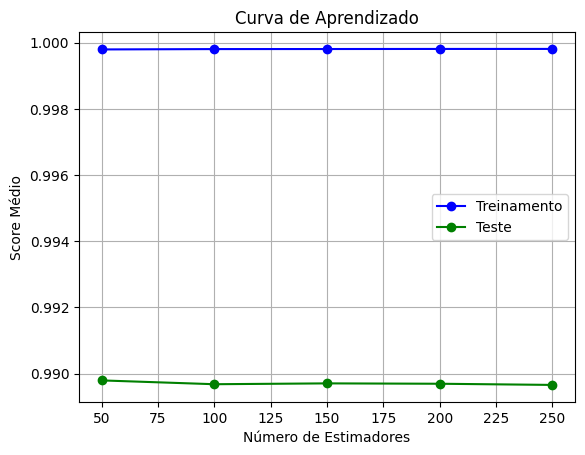

In [54]:
# Listas para armazenar os scores médios de treinamento e teste
train_scores_mean = []
test_scores_mean = []

# Criar a curva de aprendizado para cada valor de estimadores
for est in n_estimators:
    RFR = RandomForestRegressor(n_estimators=est)
    train_sizes, train_scores, test_scores = learning_curve(RFR, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Calcular as médias dos scores de treinamento e teste
    train_scores_mean.append(np.mean(train_scores))
    test_scores_mean.append(np.mean(test_scores))

# Plotar a curva de aprendizado
plt.plot(n_estimators, train_scores_mean, 'o-', label='Treinamento')
plt.plot(n_estimators, test_scores_mean, 'o-', label='Teste')
plt.xlabel('Número de Estimadores')
plt.ylabel('Score Médio')
plt.title('Curva de Aprendizado')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Nota-se que independentemente dos estimadores o desempenho do modelo se mantem, com isso será defenido uma quantidade de estimadores pequena visto o custo computacional para o modelo.

In [61]:
# Gerando o terceiro modelo
RFR = RandomForestRegressor(n_estimators=50, random_state=42)

In [62]:
# Treinando o modelo
RFR.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [63]:
# Fazendo as predições no conjunto de teste e treino
RFRy_pred_test = RFR.predict(X_test)
RFRy_pred_train = RFR.predict(X_train)

#### Avaliação do modelo

In [64]:
# Calculando o Mean Squared Error
mse_train = mean_squared_error(y_train, RFRy_pred_train)
mse_test = mean_squared_error(y_test, RFRy_pred_test)

# Calculando o R-Squared
r2_train = r2_score(y_train, RFRy_pred_train)
r2_test = r2_score(y_test, RFRy_pred_test)

# Número de observações e número de variáveis preditoras de treino
n_train = len(X_train)
p_train = X_train.shape[1]

# Número de observações e número de variáveis preditoras de teste
n_test = len(X_test)
p_test = X_test.shape[1]

# Calculando o R-Squared Ajustado
r2_ajustado_train = 1 - (1 - r2_train) * ((n_train - 1) / (n_train - p_train - 1))
r2_ajustado_test = 1 - (1 - r2_test) * ((n_test - 1) / (n_test - p_test - 1))

In [65]:
# Imprimindo as métricas de avaliação
print("Mean Squared Error (MSE) - Treinamento:", mse_train)
print("Mean Squared Error (MSE) - Teste:", mse_test)

print("R² - Treinamento:", r2_train)
print("R² - Teste:", r2_test)

print("R² ajustado - Treinamento:", r2_ajustado_train)
print("R² ajustado - Teste:", r2_ajustado_test)


Mean Squared Error (MSE) - Treinamento: 0.1079634025595289
Mean Squared Error (MSE) - Teste: 0.6131030342142538
R² - Treinamento: 0.9999033256159414
R² - Teste: 0.9993738001551026
R² ajustado - Treinamento: 0.9999033094491158
R² ajustado - Teste: 0.9993727459466095


De acordo com as métricas avaliadas o modelo possui um erro médio quadrático muito baixo, tanto nos dados de treino, quanto nos de teste e ainda possui um bom R² ajustado. 

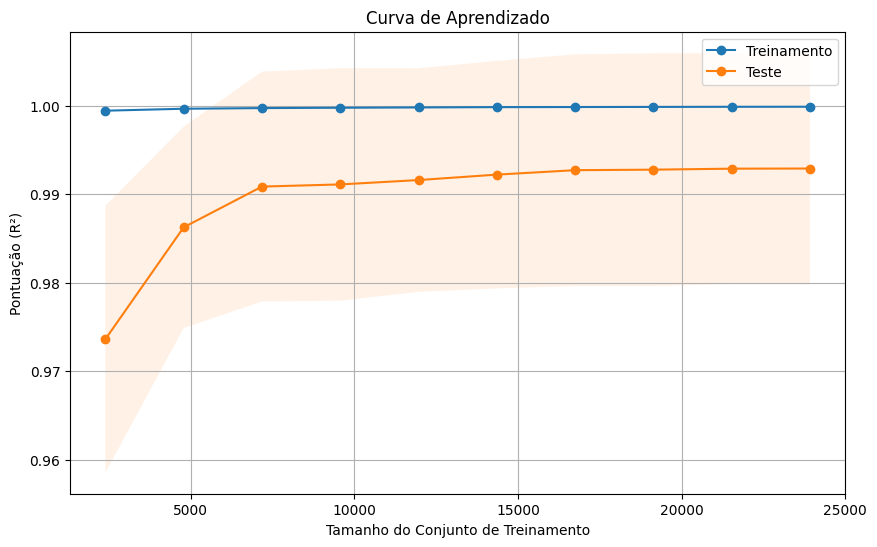

In [66]:
# Calcular a curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(RFR, X_train, y_train, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

# Calcular as médias e desvios-padrão das pontuações de treinamento e teste
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotar a curva de aprendizado
plt.figure(figsize=(10, 6))
plt.title('Curva de Aprendizado')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Pontuação (R²)')
plt.grid(True)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', label='Treinamento')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Teste')
plt.legend(loc='best')
plt.show()

## Predição do consumo mensal

### Função para calcular o consumo mensal de energia

In [119]:
# Criando função que calcula a predição mensal de consumo de energia

def Modelo_Consumo_Mensal(dataframe, modelo = 'KNN' 'LR' 'RFR'):
    
    X_test = dataframe[['cor_atrasada','cor_principal', 'med_CO2', 'fat_pot_atrasado', 'fat_pot_principal']]
    SDS = StandardScaler()
    X_train_std = SDS.fit_transform(X_train)
    X_test_std = SDS.transform(X_test)
    
    if modelo == 'KNN':
        KNN.fit(X_train_std, y_train)
        y_pred = KNN.predict(X_test_std)

    elif modelo == 'LR':
        LR.fit(X_train_std, y_train)
        y_pred = LR.predict(X_test_std)

    elif modelo == 'RFR':
        RFR.fit(X_train, y_train)
        y_pred = RFR.predict(X_test)

    return f'Consumo mensal - {y_pred.sum():.2f}'

E para finalizar, a seguir está impresso os resultados de todos os modelos

In [120]:
# Imprimindo os valores previstos e valor real do mês de Dezembro
print(f'O consumo mensal real do mês de Dezembro é de {y_test.sum():.2f}')
print('Linear Regression :', Modelo_Consumo_Mensal(test, 'LR'))
print('KNN Regression :', Modelo_Consumo_Mensal(test, 'KNN'))
print('Random Forest Regression :', Modelo_Consumo_Mensal(test, 'RFR'))


O consumo mensal real do mês de Dezembro é de 69379.17
Linear Regression : Consumo mensal - 71553.65
KNN Regression : Consumo mensal - 69335.99
Random Forest Regression : Consumo mensal - 69459.29


Os modeloso modelo apresentaram um desempenho satisfatório na previsão do consumo de energia elétrica. Ambos os modelos foram capazes de capturar as relações entre as features de entrada e a target, resultando em baixos erros de previsão e bons coeficientes de determinação (R²) tanto nos conjuntos de treinamento quanto nos conjuntos de teste. Cada modelo possui suas características e limitações específicas. Dessa forma, a escolha do modelo final dependerá da necessidade da empresa.